In [44]:
import pickle
import os
import string

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Acknowledgement

Thanks to [J. Walton's post](https://jwalton.info/Embed-Publication-Matplotlib-Latex/)---instructions for pdf-perfect plots from matplotlib.

Thanks to Sihan for writing the code to plot the IGT data.

## Load the data

In [3]:
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

stability_data = load('data/stability-data.pkl')
igt_data       = load('data/igt-data.pkl')
xigt_data      = load('data/xigt-data.pkl')

### Set the style and layout

In [4]:
TEXT_WIDTH_PT = 247.94499
INCH_TO_PT = 72.27
GOLDEN_RATIO = (5 ** 0.5 - 1) / 2

In [46]:
def convert_width(pt, fraction, n_subplots=(1,1)):
    width = pt * fraction / INCH_TO_PT
    height = width * GOLDEN_RATIO * (n_subplots[0] / n_subplots[1])
    return width, height

def set_subplots(rows, cols, fraction=0.8, hspace=0.06, wspace=0.06, sharex=True, sharey=True):
    fig, axs = plt.subplots(rows, cols, figsize=convert_width(TEXT_WIDTH_PT, fraction, (rows, cols)),
                            sharex=sharex, sharey=sharey)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
#     fig.patch.set_visible(False)
    return fig, axs

def label_subplots(axes, transpose=True, x=0.16, y=0.5):
    axes = axes.T.flat if transpose else axes.flat
    for i, axis in enumerate(axes):
        letter = string.ascii_lowercase[i]
        axis.set_title(f"({letter})", x=x, y=y)

In [62]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize":  8, # 6,
    "font.size":       8, # 6,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8, # 6,
    "xtick.labelsize": 8, # 5,
    "ytick.labelsize": 8, # 5
}
# plt.style.use('seaborn')
plt.rcParams.update(tex_fonts)

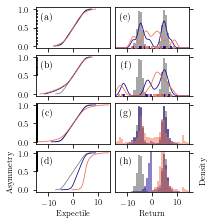

In [94]:
# fig, axes = plt.subplots(4, 2, figsize=(4, 5.2), sharex='col', sharey='col')
fig, axes = set_subplots(4, 2, sharex='col', sharey='col', wspace=0.06, hspace=0.18)
c = plt.cm.plasma

all_samples = np.concatenate(
    [stability_data[k][t]['sample']
         for k in ['opt-based imputer', 'opt-based imputer (half)',
                   'direct imputer',    'direct imputer (half)'   ]
         for t in [0, 50]
    ]
)

s_range = all_samples.min(), all_samples.max()
support = np.linspace(*s_range, 500)
bins =  np.linspace(*s_range, 50)

for i, k in enumerate(['opt-based imputer', 'opt-based imputer (half)',
                       'direct imputer',    'direct imputer (half)'   ]):
    log = stability_data[k]
    # expectiles
    axes[i, 0].plot(*log[0]['minor_expectiles'], color="gray", linewidth=0.8)
    taus = log[0]['major_expectiles'][1]
    axes[i, 0].scatter(np.full_like(taus, -15), taus,
                       marker="_", color="black", zorder=10, s=10)
    # samples
    axes[i, 1].yaxis.set_label_position("right")
    axes[i, 1].yaxis.tick_right()
    axes[i, 1].hist(log[0]['sample'], density=True, bins=bins, alpha=0.7, color="gray")
    for t in [1, 50]:
        color = c(t / 77)
        axes[i, 0].plot(*log[t]['minor_expectiles'], color=color, linewidth=0.8)
        if i < 2:
            kd = stats.gaussian_kde(log[t]['sample'], bw_method=0.18)
            axes[i, 1].plot(support, kd.pdf(support), color=color, linewidth=0.8)
            axes[i, 1].scatter(log[t]['sample'], np.zeros_like(log[1]['sample']),
                               marker="|", color=color, zorder=10, s=10)
        else:
            axes[i, 1].hist(log[t]['sample'], density=True, bins=bins, alpha=0.5,
                           color=color)

# axes[i, 0].set_ylim([0, 1])
axes[i, 0].set_xlim([-15, 15])
axes[i, 0].set_yticks([0, 0.5, 1])
axes[i, 0].set_ylabel("Asymmetry")
axes[i, 0].set_xlabel("Expectile")

axes[i, 1].set_ylim([0, 0.2])
axes[i, 1].set_xlim([-15, 15])
axes[i, 1].set_yticks([0, 0.19])
axes[i, 1].set_yticklabels([])
axes[i, 1].set_ylabel("Density")
axes[i, 1].set_xlabel("Return")

label_subplots(axes, x=0.14, y=0.55)

plt.savefig('plots/stability.pdf', bbox_inches='tight')
plt.show()

**Define `plot_single_bars` and `plot_triple_bars` for action counts**  
**Define `plot_double_bars` for state values**

In [16]:
def plot_single_bars(counts, ax, bar_width=0.2):
    ind = np.arange(4)
    data = np.array(counts)
    ax.bar(ind, data / data.sum(), bar_width, color="gray")
    ax.set_ylim(0.01, 0.99)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticks([0, 0.5])
    
    ax.tick_params(axis='x', which=u'both',length=0)
    ax.patch.set_visible(False)
    
MAX_ABS = 35

def plot_double_bars(predictions, ax, bar_width=0.2):
    table = np.zeros((2, 4))
    for k, v in predictions.items():
        idx_c, gid_c = k
        idx = ord(idx_c) - ord('A')
        gid = int(gid_c) - 1
        table[gid, idx] = v

    ind = np.arange(4)
    ax.bar(ind, table[0], bar_width, color=c(0.))
    ax.bar(ind+bar_width, table[1], bar_width, color=c(0.65))
    
    ax.set_ylim(-MAX_ABS, MAX_ABS)
    ax.set_yticks(np.linspace(-MAX_ABS+10, MAX_ABS-10, 3).astype(int))
    ax.axhline(linewidth=1, color='black')
    
    ax.tick_params(axis='x', which=u'both',length=0)
    ax.patch.set_visible(False)
    
def plot_triple_bars(counts, ax, bar_width=0.2):
    ind = np.arange(4)
    shifts = np.arange(3) * bar_width
    colors = ['gray', c(0), c(0.65)]
#     colors = ['#9467bd', '#e377c2', '#d62728']
    data = np.array(counts)
    percentage = data / data.sum(axis=1)[:, None]
    for idx, count in enumerate(percentage):
        ax.bar(ind+shifts[idx], count, bar_width, color=colors[idx])

    ax.set_ylim(0, 0.99)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.tick_params(axis='x', which=u'both',length=0)
    ax.patch.set_visible(False)

**Plot the igt data**

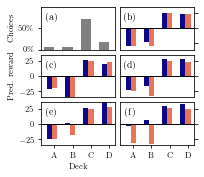

In [88]:
fig, axs = set_subplots(3, 2, sharey=False, wspace=0.06, hspace=0.12)
bar_width = 0.28
max_abs = 35
ind = np.arange(4)

# for all plot on the right, tick right
for ax in axs[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticklabels([])
axs[0, 0].set_ylabel("Choices")
axs[1, 0].set_ylabel("Pred. reward")
axs[2, 0].set_xlabel("Deck")


# plot the action counts
axs[0, 0].set_xticks(ind+bar_width)
axs[0, 0].set_xticklabels(['A', 'B', 'C', 'D'])
plot_single_bars(igt_data['traditional action counts'], axs[0, 0], bar_width=bar_width*2)

# plot the state values
plot_double_bars(igt_data['traditional'],      axs[0, 1], bar_width=bar_width)
plot_double_bars(igt_data['opt-based'],        axs[1, 0], bar_width=bar_width)
plot_double_bars(igt_data['opt-based (half)'], axs[1, 1], bar_width=bar_width)
plot_double_bars(igt_data['direct'],           axs[2, 0], bar_width=bar_width)
plot_double_bars(igt_data['direct (half)'],    axs[2, 1], bar_width=bar_width)

axs[2, 0].tick_params(axis='x', which='major',length=3)
axs[2, 1].tick_params(axis='x', which='major',length=3)

label_subplots(axs, x=0.14, y=0.55, transpose=False)
plt.savefig('plots/igt.pdf', bbox_inches='tight')
plt.show()

**Plot the xigt data**

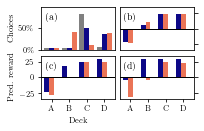

In [89]:
# plot xigt data
fig, axs = set_subplots(2, 2, sharey=False, wspace=0.06, hspace=0.12)
bar_width = 0.28
max_abs = 35
ind = np.arange(4)

# for all plot on the right, tick right
for ax in axs[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticklabels([])
axs[0, 0].set_ylabel("Choices")
axs[1, 0].set_ylabel("Pred. reward")
axs[1, 0].set_xlabel("Deck")

# plot the action counts
axs[0, 0].set_xticks(ind+bar_width)
axs[0, 0].set_xticklabels(['A', 'B', 'C', 'D'])
plot_triple_bars(
    [xigt_data['traditional action counts'],
     xigt_data['direct action counts'],
     xigt_data['direct (half) action counts']], axs[0, 0], bar_width=bar_width)

# plot the state values
plot_double_bars(xigt_data['traditional'], axs[0, 1], bar_width=bar_width)
plot_double_bars(xigt_data['direct'], axs[1, 0], bar_width=bar_width)
plot_double_bars(xigt_data['direct (half)'], axs[1, 1], bar_width=bar_width)

axs[1, 0].tick_params(axis='x', which='major',length=3)
axs[1, 1].tick_params(axis='x', which='major',length=3)

label_subplots(axs, x=0.14, y=0.55, transpose=False)
plt.savefig('plots/xigt.pdf', bbox_inches='tight')
plt.show()